In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_hub as hub
import tensorflow as tf
import string
import os
import sys
import re
import nltk
import itertools
from tensorflow import keras
from nltk import WordNetLemmatizer, pos_tag 
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import regexp_tokenize, word_tokenize, sent_tokenize, RegexpTokenizer
from nltk.stem import PorterStemmer, SnowballStemmer, LancasterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.utils import to_categorical

from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.datasets import make_classification
from wordcloud import WordCloud
from absl import logging

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aheinke/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/aheinke/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
# Pulling in our dataset with reviews on dating apps, downloaded from Kaggle
dating_df = pd.read_csv('/Users/aheinke/Documents/Flatiron/Dating_App_Sentiment/DatingAppReviewsDataset.csv').drop(columns = ['Unnamed: 0'])
dating_df

,Name,Review,Rating,#ThumbsUp,Date&Time,App
0,linah sibanda,On this app i cant find a partner,5,0,18-02-2022 01:19,Tinder
1,Norman Johnson,Tinder would be so much better if we could spe...,3,0,18-02-2022 01:16,Tinder
2,David Hume,Still doesn't correctly notify matches or mess...,1,0,18-02-2022 01:11,Tinder
3,Last 1 Standing,"Got banned because I updated my bio to say ""I ...",2,0,18-02-2022 01:11,Tinder
4,Arthur Magamedov,Love it!,5,0,18-02-2022 01:06,Tinder
...,...,...,...,...,...,...
681989,A Google user,Useless - I'm in the UK and it tells me i'm ov...,2,5,12-07-2017 01:44,Hinge
681990,Brian Shook,I can't get past the initial set up. It won't...,1,11,12-07-2017 01:36,Hinge
681991,A Google user,This is incredible! A quality dating app for A...,5,1,12-07-2017 01:32,Hinge
681992,A Google user,"""Over Water"" ... Can't choose location.",2,8,12-07-2017 01:28,Hinge


In [5]:
# Checking for how many entries we have for each rating
dating_df['Rating'].value_counts()

1    251969
5    233464
4     87347
3     56958
2     52255
0         1
Name: Rating, dtype: int64

Text(0.5, 1.0, 'App Rating')

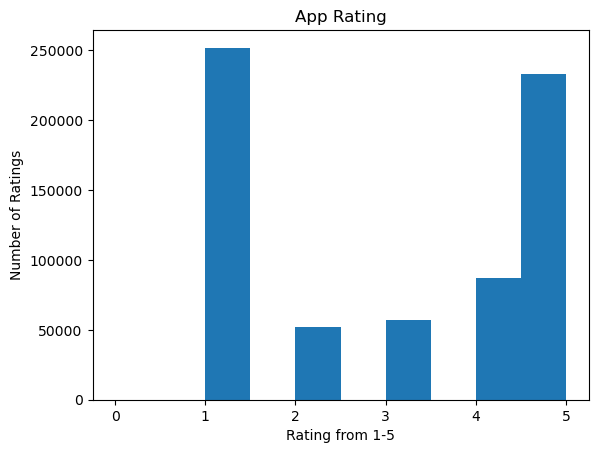

In [6]:
plt.hist(dating_df['Rating'])
plt.xlabel('Rating from 1-5')
plt.ylabel('Number of Ratings')
plt.title('App Rating')

In [7]:
dating_df['App'].value_counts()

Tinder    526616
Bumble    102384
Hinge      52994
Name: App, dtype: int64

In [8]:
app_ratings2 = dating_df.groupby(['App', 'Rating'])['Rating'].count()
app_ratings2

App     Rating
Bumble  1          40412
        2           9674
        3           8841
        4          13589
        5          29868
Hinge   1          15920
        2           4509
        3           5289
        4           8617
        5          18659
Tinder  0              1
        1         195637
        2          38072
        3          42828
        4          65141
        5         184937
Name: Rating, dtype: int64

In [9]:
# Looking at the datatypes of each of our columns and checking for any null values
dating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 681994 entries, 0 to 681993
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Name       681989 non-null  object
 1   Review     680642 non-null  object
 2   Rating     681994 non-null  int64 
 3   #ThumbsUp  681994 non-null  int64 
 4   Date&Time  681994 non-null  object
 5   App        681994 non-null  object
dtypes: int64(2), object(4)
memory usage: 31.2+ MB


In [10]:
# Changing the contents in our 'Review' column from objects to strings
dating_df['Review'] = dating_df['Review'].astype(str)

In [11]:
dating_df['Review'].str.split(',')

0                       [On this app i cant find a partner]
1         [Tinder would be so much better if we could sp...
2         [Still doesn't correctly notify matches or mes...
3         [Got banned because I updated my bio to say "I...
4                                                [Love it!]
                                ...                        
681989    [Useless - I'm in the UK and it tells me i'm o...
681990    [I can't get past the initial set up.  It won'...
681991    [This is incredible! A quality dating app for ...
681992            ["Over Water" ... Can't choose location.]
681993    [My entire town counts as "over water" and I c...
Name: Review, Length: 681994, dtype: object

In [12]:
# Verifying that our 'Review' column now includes strings
print(set(type(x) for x in dating_df['Review']))

{<class 'str'>}


In [13]:
# Taking a look at the text of one of the reviews (expecting some to be pretty funny)
dating_df['Review'][2]

"Still doesn't correctly notify matches or messages. It's a monopoly so expect zero improvement in functionality. Overpriced. The recently added features like date night ask infantile and western culture based questions. Western dating culture is pure evil. The marketing tactics are designed to manipulate and extract money from men and while hiding how the app works. An evil company enabled by unregulated capitalism/psychopathy."

In [14]:
# Tokenizing the text in the 'Review' column of our dataset 
corpus = [word_tokenize(doc) for doc in dating_df['Review']]
print(corpus[0:4])

[['On', 'this', 'app', 'i', 'cant', 'find', 'a', 'partner'], ['Tinder', 'would', 'be', 'so', 'much', 'better', 'if', 'we', 'could', 'specify', 'the', 'race', 'that', 'we', 'are', 'looking', 'for', 'instead', 'of', 'swiping', 'unnecessarily', 'though', 'EVERYONE'], ['Still', 'does', "n't", 'correctly', 'notify', 'matches', 'or', 'messages', '.', 'It', "'s", 'a', 'monopoly', 'so', 'expect', 'zero', 'improvement', 'in', 'functionality', '.', 'Overpriced', '.', 'The', 'recently', 'added', 'features', 'like', 'date', 'night', 'ask', 'infantile', 'and', 'western', 'culture', 'based', 'questions', '.', 'Western', 'dating', 'culture', 'is', 'pure', 'evil', '.', 'The', 'marketing', 'tactics', 'are', 'designed', 'to', 'manipulate', 'and', 'extract', 'money', 'from', 'men', 'and', 'while', 'hiding', 'how', 'the', 'app', 'works', '.', 'An', 'evil', 'company', 'enabled', 'by', 'unregulated', 'capitalism/psychopathy', '.'], ['Got', 'banned', 'because', 'I', 'updated', 'my', 'bio', 'to', 'say', '``',

In [15]:
# Flattening our corpus for a better understanding of what it entails
flattenedcorpus_tokens = pd.Series(list(itertools.chain(*corpus)))
print(flattenedcorpus_tokens.shape)

(12844301,)


In [16]:
# Getting a count of the amount of unique words/characters in our corpus
dictionary = pd.Series(
    flattenedcorpus_tokens.unique())
print(len(dictionary))

143861


In [17]:
# Looking at the value counts of those words/characters
# Definitely have some mis-spelled words, acronyms...a number of things that we will most likely be dropping
flattenedcorpus_tokens.value_counts()

.             609596
I             350851
to            342230
the           274477
,             253732
               ...  
protet             1
card.there         1
sitea1             1
nunbers            1
wya                1
Length: 143861, dtype: int64

In [18]:
# Looking at the top 30 of our flattened corpus
flattenedcorpus_tokens.value_counts()[0:30]

.         609596
I         350851
to        342230
the       274477
,         253732
and       250831
a         223815
app       221466
it        218555
n't       151779
you       142716
of        136740
for       135470
is        134807
!         114409
my        112080
in        100812
this       91801
's         89319
me         88834
have       88167
but        87311
on         87186
not        87038
that       83603
people     73400
with       72329
It         63321
do         60447
get        57308
dtype: int64

In [19]:
flattenedcorpus_tokens.isin(['dating']).sum()

25440

In [20]:
flattenedcorpus_tokens.isin(['Dating']).sum()

879

In [21]:
flattenedcorpus_tokens.isin(['date']).sum()

5743

In [22]:
flattenedcorpus_tokens.isin(['Date']).sum()

118

In [23]:
# Looking at the tokens with one occurenece in the corpus
num_one_occurence = (flattenedcorpus_tokens.
                     value_counts() == 1).sum()
num_one_occurence

91176

In [24]:
# Have quite a few numeric tokens that we also won't need
dictionary[dictionary.str.isnumeric()]

243           18
263            5
451            2
466           24
511          286
           ...  
142326      1983
142827       235
143458      1975
143474    140000
143801      8122
Length: 809, dtype: object

In [25]:
# Instantiating stopwords
stop_words = stopwords.words('english')
print(stop_words[0:10])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [26]:
# Looping through our corpus to remove stopwords and lowercase the leftover tokens
def first_step_normalizer(doc):
    norm_text = [x.lower() for x in word_tokenize(doc) if ((x.isalpha()) & (x not in stop_words)) ]
    return norm_text

In [27]:
# Creating a new column with our normalized reviews
dating_df['Review_norm'] = dating_df['Review'].apply(first_step_normalizer)
dating_df.head()

,Name,Review,Rating,#ThumbsUp,Date&Time,App,Review_norm
0,linah sibanda,On this app i cant find a partner,5,0,18-02-2022 01:19,Tinder,"[on, app, cant, find, partner]"
1,Norman Johnson,Tinder would be so much better if we could spe...,3,0,18-02-2022 01:16,Tinder,"[tinder, would, much, better, could, specify, ..."
2,David Hume,Still doesn't correctly notify matches or mess...,1,0,18-02-2022 01:11,Tinder,"[still, correctly, notify, matches, messages, ..."
3,Last 1 Standing,"Got banned because I updated my bio to say ""I ...",2,0,18-02-2022 01:11,Tinder,"[got, banned, i, updated, bio, say, i, feel, l..."
4,Arthur Magamedov,Love it!,5,0,18-02-2022 01:06,Tinder,[love]


In [28]:
# Taking a look at that same review from earlier after it has been normalized
print(dating_df['Review_norm'].iloc[2])

['still', 'correctly', 'notify', 'matches', 'messages', 'it', 'monopoly', 'expect', 'zero', 'improvement', 'functionality', 'overpriced', 'the', 'recently', 'added', 'features', 'like', 'date', 'night', 'ask', 'infantile', 'western', 'culture', 'based', 'questions', 'western', 'dating', 'culture', 'pure', 'evil', 'the', 'marketing', 'tactics', 'designed', 'manipulate', 'extract', 'money', 'men', 'hiding', 'app', 'works', 'an', 'evil', 'company', 'enabled', 'unregulated']


In [29]:
# Checking the amount of unique tokens after removing stopwords.
# We initally had 143,861
norm_toks_flattened = pd.Series(list(
    itertools.chain(*dating_df['Review_norm'])))
new_dictionary = norm_toks_flattened.unique()
print(len(new_dictionary))

85187


In [30]:
# Instantiating our stemmers
p_stemmer = PorterStemmer()
s_stemmer = SnowballStemmer(language = 'english')
l_stemmer = LancasterStemmer()

In [31]:
# Setting a sample review to test our stemmers/lemmatizers with
sample_rev = dating_df['Review_norm'].iloc[2]
print(sample_rev)

['still', 'correctly', 'notify', 'matches', 'messages', 'it', 'monopoly', 'expect', 'zero', 'improvement', 'functionality', 'overpriced', 'the', 'recently', 'added', 'features', 'like', 'date', 'night', 'ask', 'infantile', 'western', 'culture', 'based', 'questions', 'western', 'dating', 'culture', 'pure', 'evil', 'the', 'marketing', 'tactics', 'designed', 'manipulate', 'extract', 'money', 'men', 'hiding', 'app', 'works', 'an', 'evil', 'company', 'enabled', 'unregulated']


In [32]:
# Trying out the snowball stemmer
snowball_stemmed_rev  = [s_stemmer.stem(token) 
                     for token in sample_rev]
print(snowball_stemmed_rev)

['still', 'correct', 'notifi', 'match', 'messag', 'it', 'monopoli', 'expect', 'zero', 'improv', 'function', 'overpr', 'the', 'recent', 'ad', 'featur', 'like', 'date', 'night', 'ask', 'infantil', 'western', 'cultur', 'base', 'question', 'western', 'date', 'cultur', 'pure', 'evil', 'the', 'market', 'tactic', 'design', 'manipul', 'extract', 'money', 'men', 'hide', 'app', 'work', 'an', 'evil', 'compani', 'enabl', 'unregul']


In [33]:
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/aheinke/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/aheinke/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/aheinke/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [34]:
# Looking at the POS tagging of our sample
pos_tag(sample_rev)

[('still', 'RB'),
 ('correctly', 'RB'),
 ('notify', 'JJ'),
 ('matches', 'NNS'),
 ('messages', 'NNS'),
 ('it', 'PRP'),
 ('monopoly', 'JJ'),
 ('expect', 'JJ'),
 ('zero', 'NN'),
 ('improvement', 'NN'),
 ('functionality', 'NN'),
 ('overpriced', 'VBD'),
 ('the', 'DT'),
 ('recently', 'RB'),
 ('added', 'VBD'),
 ('features', 'NNS'),
 ('like', 'IN'),
 ('date', 'NN'),
 ('night', 'NN'),
 ('ask', 'NN'),
 ('infantile', 'NN'),
 ('western', 'JJ'),
 ('culture', 'NN'),
 ('based', 'VBN'),
 ('questions', 'NNS'),
 ('western', 'JJ'),
 ('dating', 'JJ'),
 ('culture', 'NN'),
 ('pure', 'NN'),
 ('evil', 'VBZ'),
 ('the', 'DT'),
 ('marketing', 'NN'),
 ('tactics', 'NNS'),
 ('designed', 'VBN'),
 ('manipulate', 'JJ'),
 ('extract', 'JJ'),
 ('money', 'NN'),
 ('men', 'NNS'),
 ('hiding', 'VBG'),
 ('app', 'NN'),
 ('works', 'VBZ'),
 ('an', 'DT'),
 ('evil', 'JJ'),
 ('company', 'NN'),
 ('enabled', 'VBD'),
 ('unregulated', 'JJ')]

In [35]:
# Helper function to change nltk's part of speech tagging to a wordnet format
def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:         
        return None

In [36]:
# Creates list of tokens with Wordnet format
wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tag(sample_rev))) 
print(wordnet_tagged)

[('still', 'r'), ('correctly', 'r'), ('notify', 'a'), ('matches', 'n'), ('messages', 'n'), ('it', None), ('monopoly', 'a'), ('expect', 'a'), ('zero', 'n'), ('improvement', 'n'), ('functionality', 'n'), ('overpriced', 'v'), ('the', None), ('recently', 'r'), ('added', 'v'), ('features', 'n'), ('like', None), ('date', 'n'), ('night', 'n'), ('ask', 'n'), ('infantile', 'n'), ('western', 'a'), ('culture', 'n'), ('based', 'v'), ('questions', 'n'), ('western', 'a'), ('dating', 'a'), ('culture', 'n'), ('pure', 'n'), ('evil', 'v'), ('the', None), ('marketing', 'n'), ('tactics', 'n'), ('designed', 'v'), ('manipulate', 'a'), ('extract', 'a'), ('money', 'n'), ('men', 'n'), ('hiding', 'v'), ('app', 'n'), ('works', 'v'), ('an', None), ('evil', 'a'), ('company', 'n'), ('enabled', 'v'), ('unregulated', 'a')]


In [37]:
# Instantiating our Wordnet lemmatizer
wnl = WordNetLemmatizer()
rev_lemmatized = [wnl.lemmatize(token, pos) for token, pos in wordnet_tagged if pos is not None]
print(rev_lemmatized)

['still', 'correctly', 'notify', 'match', 'message', 'monopoly', 'expect', 'zero', 'improvement', 'functionality', 'overprice', 'recently', 'add', 'feature', 'date', 'night', 'ask', 'infantile', 'western', 'culture', 'base', 'question', 'western', 'dating', 'culture', 'pure', 'evil', 'marketing', 'tactic', 'design', 'manipulate', 'extract', 'money', 'men', 'hide', 'app', 'work', 'evil', 'company', 'enable', 'unregulated']


In [38]:
# Prefer what our Wordnet Lemmatizer returns, so we are going to apply this to our corpus
# Takes in untokenized document and returns fully normalized token list
def process_rev(rev):

    wnl = WordNetLemmatizer()


    def pos_tagger(nltk_tag):
        if nltk_tag.startswith('J'):
            return wordnet.ADJ
        elif nltk_tag.startswith('V'):
            return wordnet.VERB
        elif nltk_tag.startswith('N'):
            return wordnet.NOUN
        elif nltk_tag.startswith('R'):
            return wordnet.ADV
        else:         
            return None
        
    review_norm = [tok.lower() for tok in word_tokenize(rev) if ((tok.isalpha()) & (tok not in stop_words)) ]
    
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tag(review_norm))) 
    review_norm = [wnl.lemmatize(token, pos) for token, pos in wordnet_tagged if pos is not None]
    
    return review_norm

In [39]:
# Applying the code above to our Review column
fully_normalized_corpus = dating_df['Review'].apply(process_rev)

In [40]:
fully_normalized_corpus.head()

0                           [app, cant, find, partner]
1    [tinder, much, better, specify, race, look, in...
2    [still, correctly, notify, match, message, mon...
3    [get, ban, i, updated, bio, say, i, feel, girl...
4                                               [love]
Name: Review, dtype: object

In [41]:
flattened_fully_norm = pd.Series(list(itertools.chain(*fully_normalized_corpus)))
len(flattened_fully_norm.unique())

78067

In [42]:
flattened_fully_norm.value_counts()[0:30]

i          349643
app        226859
get        105209
good        87336
match       79310
people      76090
use         66263
tinder      62204
time        55414
great       45256
account     45115
work        44952
pay         44783
profile     43867
even        43829
message     40350
try         38664
log         35514
make        34582
like        33532
say         33218
ban         32324
go          32040
date        32002
see         30488
nice        30026
meet        28069
new         27992
swipe       27174
money       26935
dtype: int64

In [43]:
flattened_fully_norm.value_counts().tail(30)

impotency       1
forcedly        1
uttterly        1
unity           1
createnew       1
bloemfontein    1
withmy          1
interviewto     1
randamly        1
lendy           1
chiste          1
etna            1
pigheaded       1
iclude          1
mojjaaa         1
subnormales     1
encontrarán     1
ahad            1
sinceros        1
muchachos       1
vrsn            1
agreeing        1
thougn          1
jjg             1
inagain         1
vvvbn           1
creap           1
courpse         1
guid            1
wya             1
dtype: int64

In [44]:
flattened_fully_norm_value_counts = flattened_fully_norm.value_counts()
count_of_single_occurrences = (flattened_fully_norm_value_counts == 1).sum()
print(count_of_single_occurrences)

46495


In [45]:
# Checking the 200 mmost frequent words
freqdist = FreqDist(flattened_fully_norm)
 
most_common = freqdist.most_common(200)
most_common

[('i', 349643),
 ('app', 226859),
 ('get', 105209),
 ('good', 87336),
 ('match', 79310),
 ('people', 76090),
 ('use', 66263),
 ('tinder', 62204),
 ('time', 55414),
 ('great', 45256),
 ('account', 45115),
 ('work', 44952),
 ('pay', 44783),
 ('profile', 43867),
 ('even', 43829),
 ('message', 40350),
 ('try', 38664),
 ('log', 35514),
 ('make', 34582),
 ('like', 33532),
 ('say', 33218),
 ('ban', 32324),
 ('go', 32040),
 ('date', 32002),
 ('see', 30488),
 ('nice', 30026),
 ('meet', 28069),
 ('new', 27992),
 ('swipe', 27174),
 ('money', 26935),
 ('keep', 26682),
 ('find', 25850),
 ('bad', 25393),
 ('fake', 25142),
 ('want', 25062),
 ('love', 23460),
 ('give', 23374),
 ('still', 23257),
 ('facebook', 23168),
 ('way', 22938),
 ('really', 21978),
 ('well', 21906),
 ('day', 21794),
 ('back', 21353),
 ('show', 21070),
 ('fix', 20912),
 ('do', 20742),
 ('let', 20582),
 ('many', 20571),
 ('update', 20445),
 ('never', 20243),
 ('not', 20127),
 ('woman', 18906),
 ('reason', 18313),
 ('need', 18265),


In [46]:
# Turning our preprocessed data into a csv
fnc_output = fully_normalized_corpus.apply(" ".join)

fnc_output.to_csv('/Users/aheinke/Documents/Flatiron/phase-5-proj/dating_norm.csv')

In [47]:
fnc_output

0                                     app cant find partner
1         tinder much better specify race look instead s...
2         still correctly notify match message monopoly ...
3         get ban i updated bio say i feel girl look plu...
4                                                      love
                                ...                        
681989    useless i uk tell water let get run little tes...
681990    i get past initial set set neighborhood think ...
681991    incredible quality date app android boyfriend wya
681992                                water choose location
681993                    entire town count water i proceed
Name: Review, Length: 681994, dtype: object

In [48]:
# Pulling in our new dataset
corpus_df = pd.read_csv('/Users/aheinke/Documents/Flatiron/phase-5-proj/dating_norm.csv').drop(columns = ['Unnamed: 0'])
corpus_df

,Review
0,app cant find partner
1,tinder much better specify race look instead s...
2,still correctly notify match message monopoly ...
3,get ban i updated bio say i feel girl look plu...
4,love
...,...
681989,useless i uk tell water let get run little tes...
681990,i get past initial set set neighborhood think ...
681991,incredible quality date app android boyfriend wya
681992,water choose location


In [49]:
corpus_df['Review'].isnull().sum()

9996

In [50]:
corpus_df['Review'].fillna('', inplace = True)

In [51]:
# Convert our preprocessed strings (normalized token sequence) to a matrix of token counts
vec = CountVectorizer(min_df = 0.02, max_df = 0.98)
X = vec.fit_transform(corpus_df['Review'])

# .get_feature_names_out() useful attribute
countvec_df = pd.DataFrame(X.toarray(), columns = vec.get_feature_names_out())
countvec_df.head()

,account,also,app,apps,back,bad,ban,best,cool,date,...,tinder,try,update,use,want,waste,way,well,woman,work
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,2,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
#tf_vec = TfidfVectorizer()
#X_tfidf = tf_vec.fit_transform(corpus_df['Review'])

#vec_tfidf = pd.DataFrame(X_tfidf.toarray(), columns = tf_vec.get_feature_names_out())
#vec_tfidf.head()

In [53]:
#download vader from nltk
nltk.download('vader_lexicon')

#creating an object of sentiment intensity analyzer
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/aheinke/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [85]:
def found_relationship(content):
    match = re.search(r"(met|found).{0,20}(husband|wife|love|partner)", content, flags=re.I)
    if match:
        return match.group(0)

In [88]:
dating_df['found_relationship'] = dating_df['Review'].fillna("").apply(found_relationship)
dating_df[(dating_df['found_relationship'].notna()) & (dating_df['Rating'] >= 4)]

,Name,Review,Rating,#ThumbsUp,Date&Time,App,Review_norm,scores,compound,pos,neg,neu,type,New_Rating,found_relationship
168,odion Angel p,Great place to found love,5,0,17-02-2022 02:19,Tinder,"[great, place, found, love]","{'neg': 0.0, 'neu': 0.265, 'pos': 0.735, 'comp...",0.8519,0.735,0.0,0.265,POS,1,found love
1010,TheColossalMan,Used it for years. One day found the love of m...,5,0,12-02-2022 13:26,Tinder,"[used, years, one, day, found, love, life, uhh...","{'neg': 0.0, 'neu': 0.563, 'pos': 0.437, 'comp...",0.8779,0.437,0.0,0.563,POS,1,found the love
1392,Dayton,5 stars. Found my wife.,5,0,10-02-2022 07:19,Tinder,"[stars, found, wife]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.000,0.0,1.000,NEUTRAL,1,Found my wife
1593,Phil Sny,I met my wife on here,5,0,09-02-2022 07:26,Tinder,"[i, met, wife]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.000,0.0,1.000,NEUTRAL,1,met my wife
1884,Borick Lalrinhlua,i met love,5,0,07-02-2022 16:56,Tinder,"[met, love]","{'neg': 0.0, 'neu': 0.192, 'pos': 0.808, 'comp...",0.6369,0.808,0.0,0.192,POS,1,met love
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
678419,A Google user,The best I've been on.. I think i found my lif...,5,0,24-10-2018 07:00,Hinge,"[the, best, i, i, think, found, life, partner,...","{'neg': 0.0, 'neu': 0.588, 'pos': 0.412, 'comp...",0.7906,0.412,0.0,0.588,POS,1,found my life partner
679342,barnaby kickflip,"Well I found the love of my life on here, so i...",5,0,17-09-2018 15:20,Hinge,"[well, i, found, love, life, worked]","{'neg': 0.0, 'neu': 0.656, 'pos': 0.344, 'comp...",0.7430,0.344,0.0,0.656,POS,1,found the love
679650,A Google user,Met the love of my life!,5,0,01-09-2018 01:31,Hinge,"[met, love, life]","{'neg': 0.0, 'neu': 0.527, 'pos': 0.473, 'comp...",0.6696,0.473,0.0,0.527,POS,1,Met the love
680111,J,Met a lovely lady.,5,0,04-08-2018 07:41,Hinge,"[met, lovely, lady]","{'neg': 0.0, 'neu': 0.345, 'pos': 0.655, 'comp...",0.5859,0.655,0.0,0.345,POS,1,Met a love


In [90]:
#import plotly.express as px
#px.pie(names = ["Did not find", "Found Relationship"], values = dating_df['found_relationship'].notna().value_counts(),\
#       color_discrete_sequence = ["pink", "lightgreen"])

ModuleNotFoundError: No module named 'plotly'

In [54]:
#creating new column scores using polarity scores function
dating_df['scores'] = dating_df['Review'].apply(lambda body: sia.polarity_scores(str(body)))
dating_df.head()

,Name,Review,Rating,#ThumbsUp,Date&Time,App,Review_norm,scores
0,linah sibanda,On this app i cant find a partner,5,0,18-02-2022 01:19,Tinder,"[on, app, cant, find, partner]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
1,Norman Johnson,Tinder would be so much better if we could spe...,3,0,18-02-2022 01:16,Tinder,"[tinder, would, much, better, could, specify, ...","{'neg': 0.0, 'neu': 0.874, 'pos': 0.126, 'comp..."
2,David Hume,Still doesn't correctly notify matches or mess...,1,0,18-02-2022 01:11,Tinder,"[still, correctly, notify, matches, messages, ...","{'neg': 0.149, 'neu': 0.773, 'pos': 0.078, 'co..."
3,Last 1 Standing,"Got banned because I updated my bio to say ""I ...",2,0,18-02-2022 01:11,Tinder,"[got, banned, i, updated, bio, say, i, feel, l...","{'neg': 0.143, 'neu': 0.802, 'pos': 0.056, 'co..."
4,Arthur Magamedov,Love it!,5,0,18-02-2022 01:06,Tinder,[love],"{'neg': 0.0, 'neu': 0.182, 'pos': 0.818, 'comp..."


In [55]:
# Adding columns for compound, positive, negative, and neutral scores
dating_df['compound'] = dating_df['scores'].apply(lambda score_dict:score_dict['compound'])
dating_df['pos'] = dating_df['scores'].apply(lambda pos_dict:pos_dict['pos'])
dating_df['neg'] = dating_df['scores'].apply(lambda neg_dict:neg_dict['neg'])
dating_df['neu'] = dating_df['scores'].apply(lambda neg_dict:neg_dict['neu'])
dating_df.head()

,Name,Review,Rating,#ThumbsUp,Date&Time,App,Review_norm,scores,compound,pos,neg,neu
0,linah sibanda,On this app i cant find a partner,5,0,18-02-2022 01:19,Tinder,"[on, app, cant, find, partner]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.000,0.000,1.000
1,Norman Johnson,Tinder would be so much better if we could spe...,3,0,18-02-2022 01:16,Tinder,"[tinder, would, much, better, could, specify, ...","{'neg': 0.0, 'neu': 0.874, 'pos': 0.126, 'comp...",0.4902,0.126,0.000,0.874
2,David Hume,Still doesn't correctly notify matches or mess...,1,0,18-02-2022 01:11,Tinder,"[still, correctly, notify, matches, messages, ...","{'neg': 0.149, 'neu': 0.773, 'pos': 0.078, 'co...",-0.7380,0.078,0.149,0.773
3,Last 1 Standing,"Got banned because I updated my bio to say ""I ...",2,0,18-02-2022 01:11,Tinder,"[got, banned, i, updated, bio, say, i, feel, l...","{'neg': 0.143, 'neu': 0.802, 'pos': 0.056, 'co...",-0.5994,0.056,0.143,0.802
4,Arthur Magamedov,Love it!,5,0,18-02-2022 01:06,Tinder,[love],"{'neg': 0.0, 'neu': 0.182, 'pos': 0.818, 'comp...",0.6696,0.818,0.000,0.182


In [56]:
# Creating one final column that outlines what each review is
dating_df['type'] = ''
dating_df.loc[dating_df.compound > 0,'type'] = 'POS'
dating_df.loc[dating_df.compound == 0,'type'] = 'NEUTRAL'
dating_df.loc[dating_df.compound < 0,'type'] = 'NEG'
dating_df.head()

,Name,Review,Rating,#ThumbsUp,Date&Time,App,Review_norm,scores,compound,pos,neg,neu,type
0,linah sibanda,On this app i cant find a partner,5,0,18-02-2022 01:19,Tinder,"[on, app, cant, find, partner]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.000,0.000,1.000,NEUTRAL
1,Norman Johnson,Tinder would be so much better if we could spe...,3,0,18-02-2022 01:16,Tinder,"[tinder, would, much, better, could, specify, ...","{'neg': 0.0, 'neu': 0.874, 'pos': 0.126, 'comp...",0.4902,0.126,0.000,0.874,POS
2,David Hume,Still doesn't correctly notify matches or mess...,1,0,18-02-2022 01:11,Tinder,"[still, correctly, notify, matches, messages, ...","{'neg': 0.149, 'neu': 0.773, 'pos': 0.078, 'co...",-0.7380,0.078,0.149,0.773,NEG
3,Last 1 Standing,"Got banned because I updated my bio to say ""I ...",2,0,18-02-2022 01:11,Tinder,"[got, banned, i, updated, bio, say, i, feel, l...","{'neg': 0.143, 'neu': 0.802, 'pos': 0.056, 'co...",-0.5994,0.056,0.143,0.802,NEG
4,Arthur Magamedov,Love it!,5,0,18-02-2022 01:06,Tinder,[love],"{'neg': 0.0, 'neu': 0.182, 'pos': 0.818, 'comp...",0.6696,0.818,0.000,0.182,POS


In [57]:
# Looping through to determine how many postive, negative, and neutral reviews our dataset contains
len = dating_df.shape
(rows, cols) = len
pos = 0
neg = 0
neutral = 0
for i in range(0, rows):
    if dating_df.loc[i][12] == 'POS':
        pos = pos + 1
    if dating_df.loc[i][12] == 'NEG':
        neg = neg + 1
    if dating_df.loc[i][12] == 'NEUTRAL':
        neutral = neutral + 1
print('Positive :' + str(pos) + '  Negative :' + str(neg) + '   Neutral :' + str(neutral))

Positive :347123  Negative :195380   Neutral :139491


In [58]:
app_sentiment = dating_df.groupby(['App', 'type'])['type'].count()
app_sentiment

App     type   
Bumble  NEG         31841
        NEUTRAL     15661
        POS         54882
Hinge   NEG         13113
        NEUTRAL      7063
        POS         32818
Tinder  NEG        150426
        NEUTRAL    116767
        POS        259423
Name: type, dtype: int64

In [59]:
# Define a function to map the rating values to 0 or 1
def map_rating(rating):
    if rating <= 2:
        return 0
    else:
        return 1

# Apply the mapping function to the 'rating' column and create a new column called 'new_rating'
dating_df['New_Rating'] = dating_df['Rating'].apply(map_rating)
dating_df.head()

,Name,Review,Rating,#ThumbsUp,Date&Time,App,Review_norm,scores,compound,pos,neg,neu,type,New_Rating
0,linah sibanda,On this app i cant find a partner,5,0,18-02-2022 01:19,Tinder,"[on, app, cant, find, partner]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.000,0.000,1.000,NEUTRAL,1
1,Norman Johnson,Tinder would be so much better if we could spe...,3,0,18-02-2022 01:16,Tinder,"[tinder, would, much, better, could, specify, ...","{'neg': 0.0, 'neu': 0.874, 'pos': 0.126, 'comp...",0.4902,0.126,0.000,0.874,POS,1
2,David Hume,Still doesn't correctly notify matches or mess...,1,0,18-02-2022 01:11,Tinder,"[still, correctly, notify, matches, messages, ...","{'neg': 0.149, 'neu': 0.773, 'pos': 0.078, 'co...",-0.7380,0.078,0.149,0.773,NEG,0
3,Last 1 Standing,"Got banned because I updated my bio to say ""I ...",2,0,18-02-2022 01:11,Tinder,"[got, banned, i, updated, bio, say, i, feel, l...","{'neg': 0.143, 'neu': 0.802, 'pos': 0.056, 'co...",-0.5994,0.056,0.143,0.802,NEG,0
4,Arthur Magamedov,Love it!,5,0,18-02-2022 01:06,Tinder,[love],"{'neg': 0.0, 'neu': 0.182, 'pos': 0.818, 'comp...",0.6696,0.818,0.000,0.182,POS,1


In [60]:
dating_df2 = dating_df[['Rating','App', 'Review_norm', 'New_Rating']]
dating_df2.head()

,Rating,App,Review_norm,New_Rating
0,5,Tinder,"[on, app, cant, find, partner]",1
1,3,Tinder,"[tinder, would, much, better, could, specify, ...",1
2,1,Tinder,"[still, correctly, notify, matches, messages, ...",0
3,2,Tinder,"[got, banned, i, updated, bio, say, i, feel, l...",0
4,5,Tinder,[love],1


In [61]:
# Going to run a logistic regression on our data
y = dating_df2['New_Rating']
X = dating_df2.drop(['New_Rating', 'App', 'Review_norm'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

In [62]:
logreg = LogisticRegression(fit_intercept = False, C = 1e12, solver = 'liblinear')
model_log = logreg.fit(X_train, y_train)
model_log

LogisticRegression(C=1000000000000.0, fit_intercept=False, solver='liblinear')

In [63]:
y_hat_train = logreg.predict(X_train)

train_residuals = np.abs(y_train - y_hat_train)
print(pd.Series(train_residuals, name = 'Residuals (counts)').value_counts())
print()
print(pd.Series(train_residuals, name = 'Residuals (proportions)').value_counts(normalize = True))

0    283369
1    228126
Name: Residuals (counts), dtype: int64

0    0.554002
1    0.445998
Name: Residuals (proportions), dtype: float64


In [64]:
y_hat_test = logreg.predict(X_test)

test_residuals = np.abs(y_test - y_hat_test)
print(pd.Series(test_residuals, name = 'Residuals (counts)').value_counts())
print()
print(pd.Series(test_residuals, name = 'Residuals (proportions)').value_counts(normalize = True))

0    94401
1    76098
Name: Residuals (counts), dtype: int64

0    0.553675
1    0.446325
Name: Residuals (proportions), dtype: float64


In [65]:
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(stop_words = 'english', ngram_range = (1,1), tokenizer = token.tokenize)
text_counts = cv.fit_transform(dating_df['Review'])

X_train, X_test, Y_train, Y_test = train_test_split(text_counts, dating_df2['New_Rating'], test_size = 0.3,\
                                                    random_state = 5)

MNB = MultinomialNB()
MNB.fit(X_train, Y_train)

predicted = MNB.predict(X_test)
acc_score = metrics.accuracy_score(predicted, Y_test)
print("Accuracy Score: ", acc_score)

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Accuracy Score:  0.8552485593771231


In [66]:
# Naive Bayes
# Assuming your preprocessed data is in a pandas dataframe called dating_df
X = dating_df2['Review_norm']  # Text data
y = dating_df2['New_Rating']    # Target variable (positive or negative)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Convert labels into numerical labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Convert text data into numerical features using a CountVectorizer
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(map(str, X_train))
X_test = vectorizer.transform(map(str, X_test))

# Train a Naive Bayes classifier on the training set
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train, y_train)

# Evaluate the classifier on the test set
y_pred = naive_bayes.predict(X_test)
acc = accuracy_score(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {acc}")
print("Confusion matrix:\n", confusion_mat)

Accuracy: 0.8588919273601713
Confusion matrix:
 [[51559  9281]
 [ 9966 65593]]


In [67]:
# Assuming your preprocessed data is in a pandas dataframe called dating_df2
X = dating_df2['Review_norm']  # Text data
y = dating_df2['New_Rating']    # Target variable (positive or negative)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

# Convert text data into numerical features using a TF-IDF vectorizer
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train.astype(str))
X_test = vectorizer.transform(X_test.astype(str))

# Train a LinearSVC classifier on the training set
clf = LinearSVC()
clf.fit(X_train, y_train)

# Use the trained classifier to predict the sentiment of the text in the testing set
y_pred = clf.predict(X_test)

# Evaluate the performance of the classifier
accuracy = accuracy_score(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion matrix:\n", confusion_mat)

Accuracy: 0.8695298352627219
Confusion matrix:
 [[52729  8116]
 [ 9680 65874]]


In [68]:
# Generate some dummy data
X, y = make_classification(n_samples = 1000, n_features = 10, n_informative = 5, n_classes = 2, random_state = 42)

# Instantiate the Linear SVC model
svc = LinearSVC()

# Perform 5-fold cross-validation
scores = cross_val_score(svc, X, y, cv = 5)

# Print the average accuracy and standard deviation across the 5 folds
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.82 (+/- 0.04)


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear fa

In [69]:
# Perform k-fold cross-validation on the Linear SVC model
scores = cross_val_score(clf, X, y, cv = 5)
print("Cross-validation scores:", scores)
print("Average accuracy:", scores.mean())

# Calculate precision, recall, F1 score, and confusion matrix
y_pred = clf.predict(X_test)
print("Classification report:\n", classification_report(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Cross-validation scores: [0.82  0.8   0.85  0.84  0.805]
Average accuracy: 0.8230000000000001


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Classification report:
               precision    recall  f1-score   support

           0       0.84      0.87      0.86     60845
           1       0.89      0.87      0.88     75554

    accuracy                           0.87    136399
   macro avg       0.87      0.87      0.87    136399
weighted avg       0.87      0.87      0.87    136399

Confusion matrix:
 [[52729  8116]
 [ 9680 65874]]


In [70]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(dating_df2['Review_norm'], dating_df2['New_Rating'],\
                                                    test_size = 0.2, random_state = 42)

# Convert the text data into numerical features using TF-IDF vectorization
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train.astype(str))
X_test = vectorizer.transform(X_test.astype(str))

# Train a Random Forest Classifier on the training set
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Use the trained classifier to predict the sentiment of the text in the testing set
y_pred = clf.predict(X_test)

# Evaluate the performance of the classifier
accuracy_sc = accuracy_score(y_test, y_pred)
con_mat = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy_sc)
print("Confusion matrix:\n", con_mat)

Accuracy: 0.8678949259158791
Confusion matrix:
 [[54917  5923]
 [12096 63463]]


In [71]:
# Load the data and split into training and testing sets
X = dating_df2['Review_norm']
y = dating_df2['New_Rating'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Convert the text data into numerical features using TF-IDF vectorization
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train.astype(str))
X_test = vectorizer.transform(X_test.astype(str))

# Train a Gradient Boosting Classifier on the training set
clf = GradientBoostingClassifier()
clf.fit(X_train, y_train)

# Use the trained classifier to predict the sentiment of the text in the testing set
y_pred = clf.predict(X_test)

# Evaluate the performance of the classifier
acc_sc = accuracy_score(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

print("Accuracy:", acc_sc)
print("Confusion matrix:\n", confusion_mat)

Accuracy: 0.806288902411308
Confusion matrix:
 [[41948 18892]
 [ 7530 68029]]


In [72]:
# Assuming your preprocessed data is in a pandas dataframe called dating_df
X = dating_df2['Review_norm']  # Text data
y = dating_df2['New_Rating']    # Target variable (positive or negative)

# Tokenize the text data
tokenizer = Tokenizer(num_words = 10000)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
X = pad_sequences(sequences, maxlen = 100)

# Convert target variable to categorical data
y = to_categorical(y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Train a simple RNN
rnn_model = Sequential()
rnn_model.add(Embedding(input_dim = 10000, output_dim = 64, input_length = 100))
rnn_model.add(LSTM(64, return_sequences = True))
rnn_model.add(GlobalMaxPooling1D())
rnn_model.add(Dense(64, activation = 'relu'))
rnn_model.add(Dense(2, activation = 'softmax'))
rnn_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
rnn_model.fit(X_train, y_train, epochs = 10, batch_size = 128, validation_split = 0.2)

# Evaluate the performance of the models on the testing set
rnn_acc = accuracy_score(y_test.argmax(axis = 1), rnn_model.predict(X_test).argmax(axis = 1))
rnn_confusion_mat = confusion_matrix(y_test.argmax(axis = 1), rnn_model.predict(X_test).argmax(axis = 1))

print("RNN Accuracy:", rnn_acc)
print("RNN Confusion matrix:\n", rnn_confusion_mat)

Metal device set to: Apple M2


2023-04-13 16:36:48.554409: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-13 16:36:48.555265: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/10


2023-04-13 16:36:49.156574: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-13 16:36:49.606554: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-13 16:36:49.824784: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-13 16:36:51.783322: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3410/3410 [==============================] - ETA: 0s - loss: 0.3115 - accuracy: 0.8683

2023-04-13 16:41:40.350028: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-13 16:41:40.391137: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3410/3410 [==============================] - 303s 88ms/step - loss: 0.3115 - accuracy: 0.8683 - val_loss: 0.2894 - val_accuracy: 0.8811
Epoch 2/10
3410/3410 [==============================] - 277s 81ms/step - loss: 0.2770 - accuracy: 0.8872 - val_loss: 0.2834 - val_accuracy: 0.8837
Epoch 3/10
3410/3410 [==============================] - 249s 73ms/step - loss: 0.2619 - accuracy: 0.8941 - val_loss: 0.2861 - val_accuracy: 0.8843
Epoch 4/10
3410/3410 [==============================] - 229s 67ms/step - loss: 0.2488 - accuracy: 0.9006 - val_loss: 0.2919 - val_accuracy: 0.8818
Epoch 5/10
3410/3410 [==============================] - 236s 69ms/step - loss: 0.2356 - accuracy: 0.9068 - val_loss: 0.3033 - val_accuracy: 0.8812
Epoch 6/10
3410/3410 [==============================] - 229s 67ms/step - loss: 0.2216 - accuracy: 0.9127 - val_loss: 0.3196 - val_accuracy: 0.8795
Epoch 7/10
3410/3410 [==============================] - 230s 68ms/step - loss: 0.2074 - accuracy: 0.9192 - val_loss: 0.3357 - val

2023-04-13 17:17:38.047976: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-13 17:17:38.099924: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4263/4263 [==============================] - 40s 9ms/step
RNN Accuracy: 0.8707321901186958
RNN Confusion matrix:
 [[52863  7977]
 [ 9655 65904]]


In [73]:
tinder_pos_df = dating_df2[(dating_df2['App'] == 'Tinder') & (dating_df2['New_Rating'] == 1)]
tinder_pos_df.head()

,Rating,App,Review_norm,New_Rating
0,5,Tinder,"[on, app, cant, find, partner]",1
1,3,Tinder,"[tinder, would, much, better, could, specify, ...",1
4,5,Tinder,[love],1
5,5,Tinder,"[good, app]",1
6,5,Tinder,"[its, great, app, find, expensive]",1


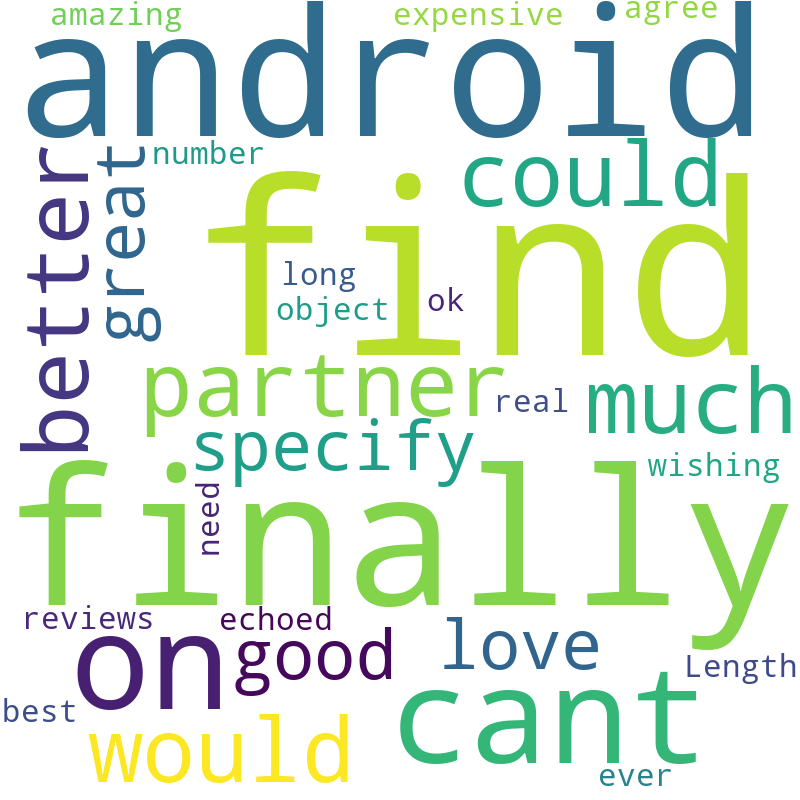

In [74]:
wordcloud = WordCloud(width = 800, height = 800, stopwords = ['app', 'tinder', 'i', 'its', 'Review_norm', 'upda',\
                                                              'Name', 'dtype'],
                      background_color = 'white').generate(str(tinder_pos_df['Review_norm']))
wordcloud.to_image()

In [75]:
tinder_neg_df = dating_df2[(dating_df2['App'] == 'Tinder') & (dating_df2['New_Rating'] == 0)]
tinder_neg_df.head()

,Rating,App,Review_norm,New_Rating
2,1,Tinder,"[still, correctly, notify, matches, messages, ...",0
3,2,Tinder,"[got, banned, i, updated, bio, say, i, feel, l...",0
7,1,Tinder,"[just, tested, originally, noticing, flux, esc...",0
10,2,Tinder,"[i, know, i, banned, happened, i, really, unde...",0
12,1,Tinder,"[they, banned, account, without, anything]",0


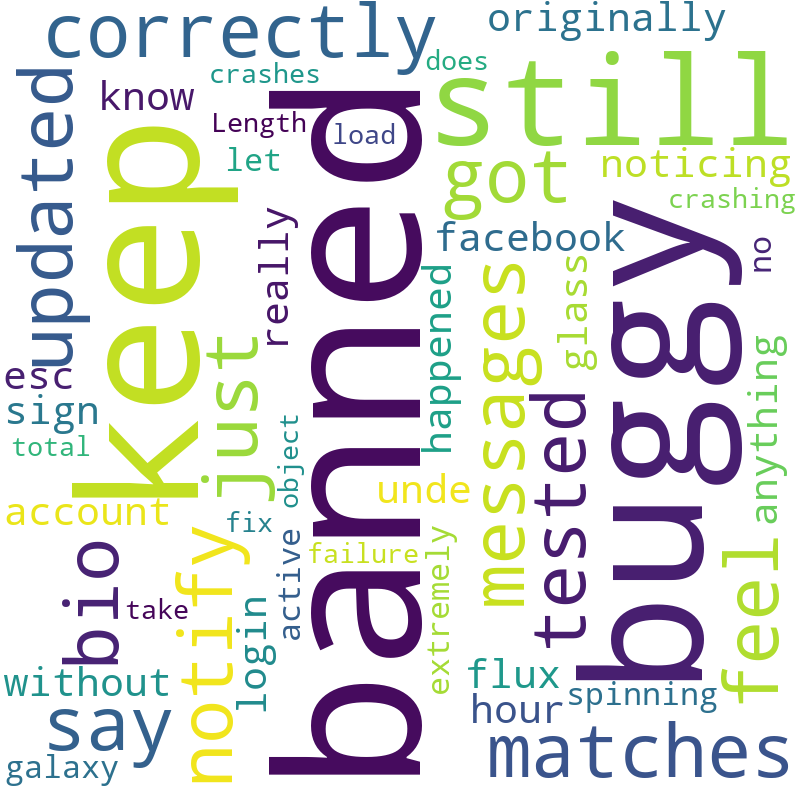

In [76]:
wordcloud = WordCloud(width = 800, height = 800, stopwords = ['app', 'tinder', 'i', 'its', 'Review_norm', 'upda',\
                                                              'Name', 'dtype', 'y', 'l', 'they'],
                      background_color = 'white').generate(str(tinder_neg_df['Review_norm']))
wordcloud.to_image()

In [77]:
bumble_pos_df = dating_df2[(dating_df2['App'] == 'Bumble') & (dating_df2['New_Rating'] == 1)]
bumble_pos_df.head()

,Rating,App,Review_norm,New_Rating
526616,4,Bumble,"[dacă, nu, ar, cere, mereu, bani, pentru, oric...",1
526620,5,Bumble,"[pretty, good, far]",1
526624,4,Bumble,"[not, paying, member, so, far, i, found, ladie...",1
526627,3,Bumble,"[ms, wolfe, subsidizing, abortions, texas]",1
526629,5,Bumble,[love],1


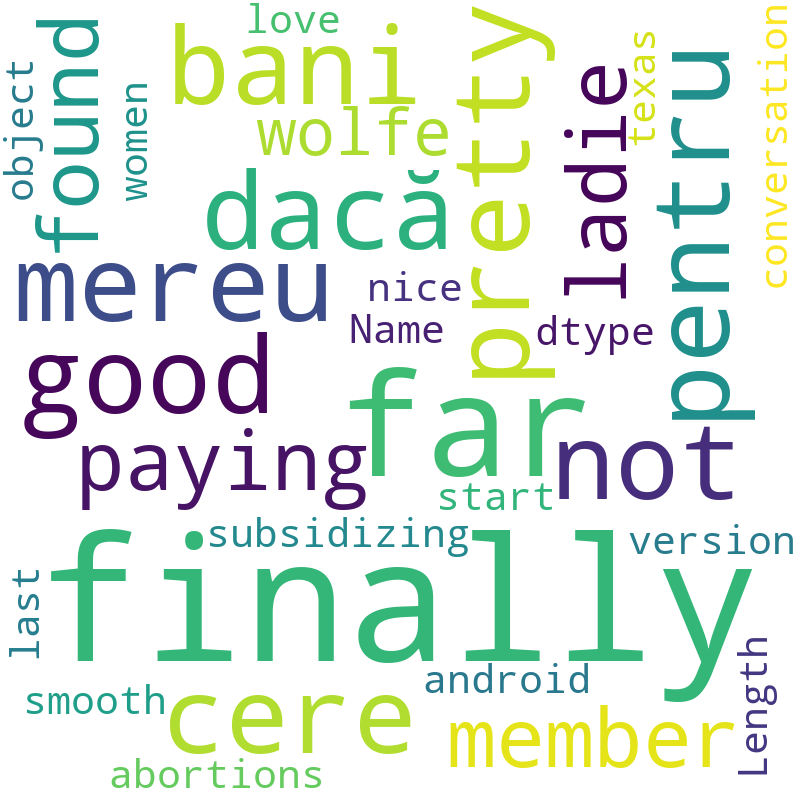

In [78]:
wordcloud = WordCloud(width = 800, height = 800, stopwords = ['app', 'bumble', 'i', 'its', 'Review_norm', 'ms', 'nu',\
                                                             'so', 'ar', 'at', 'lov', 'oric'],
                      background_color = 'white').generate(str(bumble_pos_df['Review_norm']))
wordcloud.to_image()

In [79]:
bumble_neg_df = dating_df2[(dating_df2['App'] == 'Bumble') & (dating_df2['New_Rating'] == 0)]
bumble_neg_df.head()

,Rating,App,Review_norm,New_Rating
526617,1,Bumble,"[ca, seem, log, account, i, tried, many, diffe...",0
526618,1,Bumble,"[limited, views, without, paying, money, fake,...",0
526619,1,Bumble,"[this, trusted, worst, app, this, app, trust, ...",0
526621,1,Bumble,"[just, money, grab, i, used, love, app, starte...",0
526622,1,Bumble,"[the, app, crapp, if, i, switch, away, app, an...",0


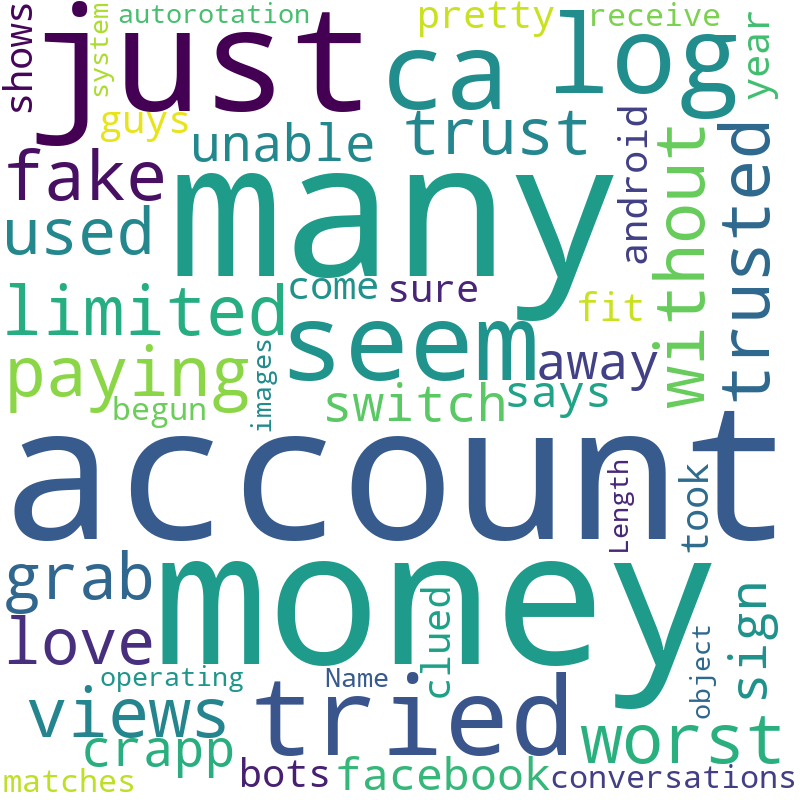

In [80]:
wordcloud = WordCloud(width = 800, height = 800, stopwords = ['app', 'bumble', 'i', 'its', 'Review_norm', 'ms', 'nu',\
                                                             'so', 'ar', 'at', 'lov', 'oric', 'cl', 'the', 'an',\
                                                              'dtype', 'diffe', 'my', 'if', 'it', 'this', 'starte'],
                      background_color = 'white').generate(str(bumble_neg_df['Review_norm']))
wordcloud.to_image()

In [81]:
hinge_pos_df = dating_df2[(dating_df2['App'] == 'Hinge') & (dating_df2['New_Rating'] == 1)]
hinge_pos_df.head()

,Rating,App,Review_norm,New_Rating
629000,5,Hinge,[perfect],1
629002,5,Hinge,"[found, someone, and, counts]",1
629004,4,Hinge,"[needs, darkmode, so, white, it, flashes, scre...",1
629009,3,Hinge,"[okay, sets]",1
629012,3,Hinge,"[still, new, app, feels, great, use]",1


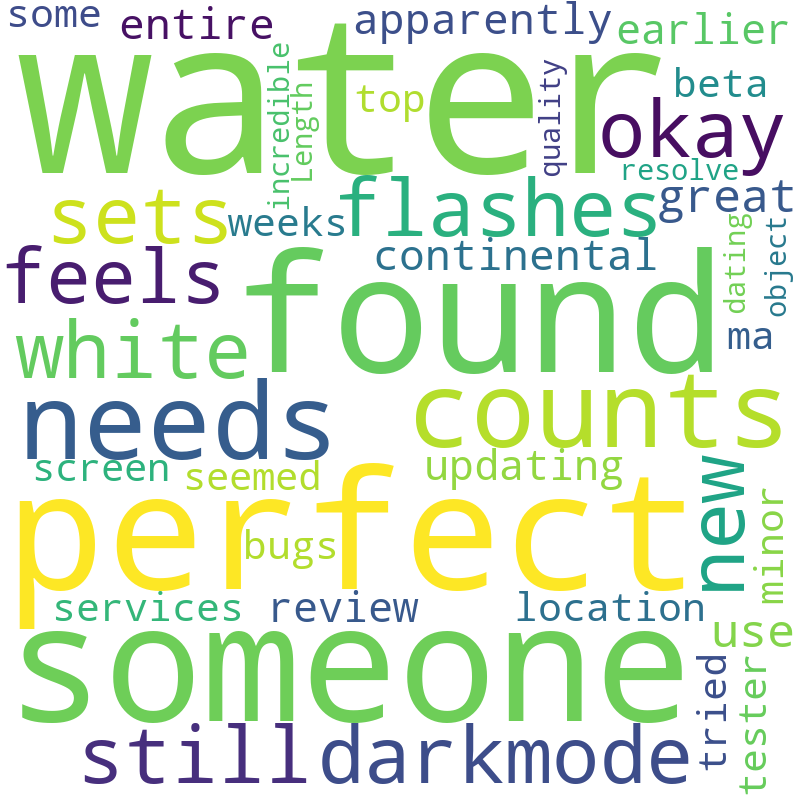

In [82]:
wordcloud = WordCloud(width = 800, height = 800, stopwords = ['app', 'i', 'it', 'hinge', 'Review_norm', 'they', 'my',\
                                                             'this', 'popu', 'wo', 'showi', 'r', 'an', 'c', 'a', 'us',\
                                                             'dtype', 'scre', 'Name', 'so', 'and'],
                      background_color = 'white').generate(str(hinge_pos_df['Review_norm']))
wordcloud.to_image()

In [83]:
hinge_neg_df = dating_df2[(dating_df2['App'] == 'Hinge') & (dating_df2['New_Rating'] == 0)]
hinge_neg_df.head()

,Rating,App,Review_norm,New_Rating
629001,2,Hinge,"[there, may, truth, hinge, claims, app, delete...",0
629003,1,Hinge,"[this, app, horribly, messed, they, take, popu...",0
629005,1,Hinge,"[horrible, app, this, app, hinge, worth, zero,...",0
629006,1,Hinge,"[it, called, dating, app, reason, date, great,...",0
629007,1,Hinge,"[constantly, glitching, losing, matches, showi...",0


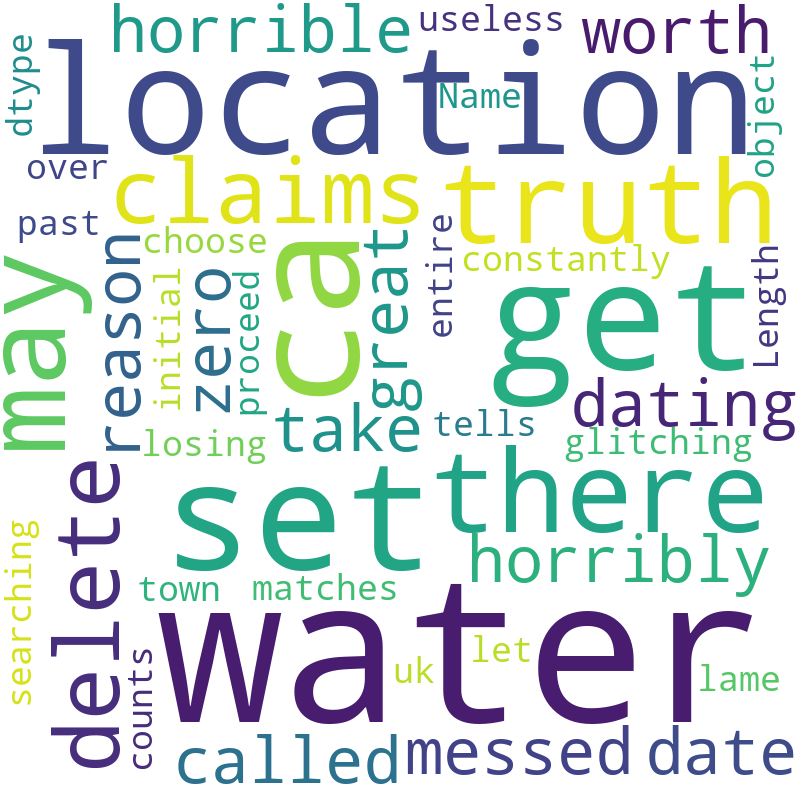

In [84]:
wordcloud = WordCloud(width = 800, height = 800, stopwords = ['app', 'i', 'it', 'hinge', 'Review_norm', 'they', 'my',\
                                                             'this', 'popu', 'wo', 'showi', 'r'],
                      background_color = 'white').generate(str(hinge_neg_df['Review_norm']))
wordcloud.to_image()

In [1]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return model(input)

ModuleNotFoundError: No module named 'tensorflow_hub'